In [1]:
import pandas as pd, numpy as np, pymc as pm

In [2]:
import matplotlib.pyplot as plt

- pull in age x sex structure for a specific block

- pull in decennial hh sizes
- assign arbitrary hhids, relationships

- run mcmc

# Test out household structure assignment with mcmc

Objective: given a synthetic dataset that contains, for each individual, their census block, precise age, sex, and precise race, assign a realistic household structure (wrt household ids and relationships to head of household) using distributions from the 2010 decennial.

## pull in data

This is synthetic data; it was generated using the 2010 decennial and the 2018 acs (should switch to 2010)

It has fairly accurate age, sex, and race distribution for each census block. The relationship and ethnicity (hispanic binary) columns are bad, because they are informed only by the state-level distribution of each var from the ACS. We will scrap those relationship assigments and reassign them using MCMC and the block-level decennial data. The inaccuracy of the ethnicity still needs to be addressed.

In [3]:
## pull in age-sex structure for a single block
df = pd.read_csv('/home/j/temp/beatrixh/sim_science/outputs/example_hh_structure_assignment/ravenna_07_14_2020.csv')

In [4]:
df = df.drop(columns='relationship')
df.head()

,state,county,tract,block,age,sex_id,hispanic,racaian,racasn,racblk,racnhpi,racsor,racwht,pweight,geoid
0,53,33,4301,3011,22,1,0,0,0,1,0,0,1,1,530330043013011
1,53,33,4301,3011,52,1,0,0,0,0,0,0,1,1,530330043013011
2,53,33,4301,3011,71,1,0,0,0,0,0,0,1,1,530330043013011
3,53,33,4301,3011,38,2,0,0,0,0,0,0,1,1,530330043013011
4,53,33,4301,3011,37,2,0,0,0,0,0,0,1,1,530330043013011


In [5]:
## pull in df to fit to from decennial
input_dir = '/home/j/temp/beatrixh/sim_science/decennial_census_2010/'
location_cols = ['STATE', 'COUNTY', 'TRACT', 'BLKGRP', 'BLOCK']
household_sizes = ['P02800' + ('00' + str(i))[-2:] for i in np.arange(1,17)]
relations_present = ['P02900' + ('00' + str(i))[-2:] for i in np.arange(1,29)]
household_type = ['P03000' + ('00' + str(i))[-2:] for i in np.arange(1,14)]

In [6]:
# this is the 2010 decennial for a single block in ravenna
ravenna = pd.read_csv('/home/j/temp/beatrixh/sim_science/outputs/example_hh_structure_assignment/decennial_ravenna_07_20_2020.csv')

## prep vars of interest

Decennial var labels from https://www2.census.gov/programs-surveys/decennial/2010/technical-documentation/complete-tech-docs/summary-file/sf1.pdf?#

In [7]:
#relationship to head of hh
relp_labels = ['total', 'in_households', 'in_family_households',
               'householders_family', 'male_householder_family', 
               'female_householder_family', 'spouse', 'biological_child',
               'adopted_child', 'stepchild', 'grandchild', 'sibling', 
               'parent', 'parent_in_law', 'child_in_law', 
               'other_relatives', 'nonrelatives', 
               'in_nonfamily_households', 
               'male_householder_nonfamily','male_householder_nonfamily_alone','male_householder_nonfamily_not_alone', 
               'female_householder_nonfamily', 'female_householder_nonfamily_alone','female_householder_nonfamily_not_alone', 
               'nonrelatives_nonfamily',
               'in_gq','gq_inst','gq_noninst']

ravenna_relps = ravenna[relations_present].melt(value_name = 'counts', var_name = 'relp')
ravenna_relps['decennial_relp'] = relp_labels

#these will be onto and mutually exclusive, but not 1:1 or defined on the entire domain
decennial_acs_relp_dict = {'householders_family':0,
                           'male_householder_nonfamily':0.5,
                           'female_householder_nonfamily':0.5,
                           'spouse':1,
                          'biological_child':2,
                          'adopted_child':3,
                          'stepchild':4,
                          'sibling':5,
                          'parent':6,
                          'grandchild':7,
                          'parent_in_law':8,
                          'child_in_law':9,
                          'other_relatives':10,
                          'nonrelatives':14, #NOTE IN ACS, 14 IS FOSTER CHILDREN. 
                          'nonrelatives_nonfamily':15, #refine this
                          'gq_inst':16,
                          'gq_noninst':17} #same-sex spouses were mapped to nonrelatives

ravenna_relps['relp_id'] = ravenna_relps.decennial_relp.map(decennial_acs_relp_dict)
ravenna_relps = ravenna_relps[ravenna_relps.relp_id.notna()]
ravenna_relps = ravenna_relps.drop(columns=['relp','decennial_relp'])
ravenna_relps = ravenna_relps.groupby('relp_id').sum().reset_index()

In [8]:
## household type
hh_type_labels = ['total','in_family_hh',
                  'in_husband_wife_family',
                  'in_other_family','in_male_head_no_wife',
                  'in_female_head_no_husband','in_non_family',
                  'non_family_male_head','non_family_male_head_alone',
                  'non_family_male_head_not_alone',
                  'non_family_female_head','non_family_female_head_alone',
                  'non_family_female_head_not_alone']

ravenna_hh_types = ravenna[household_type].melt(value_name = 'counts', var_name = 'hh_type')
ravenna_hh_types['hh_type_label'] = hh_type_labels

In [9]:
## household ids
ravenna_hhs = ravenna[household_sizes].melt(value_name = 'counts', var_name = 'hh_size')

## map census vars to household sizes
d = {}
d.update({i:int(i[-1])-1 for i in ravenna.columns[8:14]})
d.update({i:int(i[-1])+1 for i in ravenna.columns[15:]})

ravenna_hhs['hh_size'] = ravenna_hhs.hh_size.map(d)
ravenna_hhs = ravenna_hhs[ravenna_hhs.hh_size.notna()]
ravenna_hhs = ravenna_hhs.groupby('hh_size').sum().reset_index()

In [10]:
n_households = ravenna_hhs['counts'].sum()
n_sims = df.pweight.sum()

print(f'''n_households: {n_households}
n_simulants: {n_sims}''')

n_households: 24
n_simulants: 65


## mcmc

initialize with uniform priors, then add in constraints using decennial block-level data

In [11]:
hhid = pm.DiscreteUniform('hhid', 0, n_households-1, size=n_sims)
relp = pm.DiscreteUniform('relp', 0, ravenna_relps.relp_id.max(), size = n_sims)
family_hh = pm.DiscreteUniform('family_hh', 0, 1, size = n_sims)

In [12]:
#make sure there are exactly n_households hhids
@pm.potential
def hh_count_constraint_soft(hhid=hhid, n_households=n_households):
    diff = len(np.unique(hhid)) - n_households
    return -1*(diff)**2

In [13]:
#make sure there are exactly n_households hh_heads, with correct family vs nonfamily distribution
@pm.potential
def hhid_count_constraint_soft(relp=relp, family_hh=family_hh, target_relps=ravenna_relps):    
    # count hh_heads in family and nonfam hhs
    df = pd.DataFrame({'relp':relp, 'family_hh':family_hh})
    fam_heads = df[(df.family_hh==1) & (df.relp==0)].shape[0]
    nonfam_heads = df[(df.family_hh==0) & (df.relp==0)].shape[0]

    # penalize extra or missing heads per famliy vs nonfamily categories
    # note that for one head out of place, up to 4x the penalization. consider changing.
    diff = np.abs(fam_heads - target_relps[target_relps.relp_id==0].counts.values[0])
    diff += np.abs(nonfam_heads - target_relps[target_relps.relp_id==0.5].counts.values[0])
    
    return -1*(diff)**2

In [14]:
#make sure one hh_head per hhid
@pm.potential
def one_head_per_hh_soft_constraint(relp=relp, hhid=hhid):
    #count hh_heads
    hh_heads = [1 if i<1 else 0 for i in relp]
    
    #enumerate per hhid
    heads_per_hh = pd.DataFrame({'hhid':hhid,'hh_head':hh_heads})
    heads_per_hh = heads_per_hh.groupby('hhid').sum()
    
    #look at how far from 1 per hh each is
    heads_per_hh.hh_head -= 1
    
    return -sum(heads_per_hh.hh_head.abs())**2

In [15]:
#make sure correct # of family_hhs, and that they are consistent across hh_ids
@pm.potential
def family_hh_constraint(relp=relp, hhid=hhid, family_hh=family_hh, target_hh_types = ravenna_hh_types):
    # are the correct number of people in family_hhs?
    distance_to_family_hh_count = np.abs(sum(family_hh) - target_hh_types[target_hh_types.hh_type_label=='in_family_hh'].counts)
    
    
    # do people in the same hh have the same family_hh status?
    df = pd.DataFrame({'hhid':hhid, 'family_hh':family_hh}).groupby('hhid').mean().rename(columns={'family_hh':'mean_val'})
    weight = pd.DataFrame({'hhid':hhid, 'family_hh':family_hh}).groupby('hhid').count().rename(columns={'family_hh':'weight'})
    df = df.merge(weight, on = 'hhid')
    
    #subste to hhids in which everyone does not have the same family_hh status
    df = df[~df.mean_val.isin([0,1])]
    
    # determine what percent need to flip
    df['err'] = np.abs(np.round(df.mean_val)-df.mean_val)
    
    # weight it by how many need to flip
    df['weighted_error'] = df.weight * df.err
    inconsistent_family_hhs = df.weighted_error.sum()

    return -1*(distance_to_family_hh_count + inconsistent_family_hhs)

In [16]:
#make sure there are correct total #spouses, leq 1 spouse per family hh, and 0 spouse per non family hh
@pm.potential
def assign_spouses_correctly_soft_constraint(relp=relp, hhid=hhid, family_hh=family_hh, target_relps=ravenna_relps):
    # pull all vars
    df = pd.DataFrame({'relp':relp, 'hhid': hhid, 'family_hh':family_hh})
    fam = df[df.family_hh==1]
    non_fam = df[df.family_hh==0]
    
    #enumerate extra spouses in family hhs with >1 spouse
    fam.loc[:,'spouses_count'] = [1 if i==1 else 0 for i in fam.relp]
    fam = fam.groupby('hhid').sum()
    extra_spouses_fam = sum([i-1 if i>1 else 0 for i in fam.spouses_count])
    
    #enumerate extra spouses in non family hhs (should this be penalized more?)
    extra_spouses_nonfam = sum([1 if i==1 else 0 for i in non_fam.relp])
    
    #enumerate missing spouses
    all_spouses = sum([1 if i==1 else 0 for i in relp])
    target_spouses = target_relps[target_relps.relp_id==1].counts.values[0]
    spouse_error = np.abs(all_spouses - target_spouses)
    
    return -1*(extra_spouses_fam + extra_spouses_nonfam + spouse_error)

/share/code/beatrixh/miniconda/envs/mcmc/lib/python3.6/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/share/code/beatrixh/miniconda/envs/mcmc/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [17]:
# ensure that nonfamily nonrelatives all go to nonfamily HHs, and no one else does
@pm.potential
def assign_nonfamily_nonrelatives_soft_constraint(relp=relp, hhid=hhid, family_hh=family_hh):
    df = pd.DataFrame({'relp':relp, 'hhid': hhid, 'family_hh':family_hh})
    fam = df[(df.family_hh==1) & (df.relp==15)].shape[0]
    non_fam = df[(df.family_hh==0) & (~df.relp.isin([0,15]))].shape[0]

    return -1*(fam + non_fam)**2

In [18]:
#ensure all single-person households are non-family
@pm.potential
def constrain_single_person_hh(hhid=hhid, family_hh=family_hh):
    df= pd.DataFrame({'hhid':hhid,'family_hh':family_hh})
    df['weight'] = 1
    
    #count people per hhid
    df = df.groupby('hhid').sum()
    
    #select single person households designated as family
    single_person_families = df[(df.weight==1) & (df.family_hh==1)].shape[0]
    
    return -1*single_person_families

In [19]:
# Maybe these should be used for validation after-the-fact, instead of as constraints?


################################################################
#constrain towards correct relationship assignment distribution
@pm.potential
def relp_distribution_constraint_soft(relp=relp, target_dist = ravenna_relps):
    #reassign non-family heads back to hh_heads
    target = target_dist.copy()
    target['relp_id'] = target.relp_id.round()
    target = target.groupby('relp_id').sum().reset_index(drop=False)
    
    #count relp distribution in sim data
    sim_relps = pd.DataFrame({'relps':relp}).relps.value_counts()
    sim_relps = pd.DataFrame(sim_relps).reset_index().rename(columns={'index':'relp_id','relps':'sim_counts'})

    #compare to target distribution
    compare = sim_relps.merge(target, on='relp_id', how = 'outer').fillna(0)
    compare['abs_diff'] = np.abs(compare.sim_counts - compare.counts)
    
    return -compare.abs_diff.sum()**2

#constrain towards correct houshold sizes
@pm.potential
def hh_size_distribution_constraint_soft(hhid=hhid, target=ravenna_hhs):
    #count hh_size distribution in sim data
    sim_hh_sizes = pd.DataFrame({'hhids':hhid}).hhids.value_counts().value_counts()
    sim_hh_sizes = pd.DataFrame(sim_hh_sizes).reset_index().rename(columns={'index':'hh_size','hhids':'sim_counts'})
    
    #compare to target distribution
    compare = sim_hh_sizes.merge(target, on = 'hh_size', how = 'outer').fillna(0)
    compare['abs_diff'] = np.abs(compare.sim_counts - compare.counts)
    
    return -compare.abs_diff.sum()**2

In [20]:
# constrain towards a realistic set of age relationships.
# should hh_head have a requisite minimum age?

# right now the penalization is worse if the age gap is more egregious.
# should it just be a fn of the count of unrealistic age relps?

@pm.potential
def age_relp_consistency_constraint(hhid=hhid, relp=relp, family_hh=family_hh, age_sex=df):
    same_gen = [1,5,]
    child_gen = [2,3,4,9]
    parent_gen = [6,8]
    grandchild_gen = [7]
    fam_ids = same_gen + child_gen + parent_gen + grandchild_gen
    
    #merge relp, hhid, and family_hh onto age/sex/race structure
    synth = age_sex.copy()
    synth['relp'] = relp
    synth['hhid'] = hhid
    synth['family_hh'] = family_hh
    #subset to families
    synth = synth[synth.family_hh==1]
    
    #pull all hh heads
    ref_age = synth.loc[synth.relp==0,['age','hhid']]
    
    # deal with households that still have multiple heads.
    ref_age = ref_age.groupby('hhid').mean().reset_index()
    ref_age = ref_age.rename(columns={'age':'ref_age'})

    # merge hh_head age onto population
    dt = synth.merge(ref_age, on = 'hhid', how = 'left')[['age','relp','hhid','family_hh','ref_age']]

    # ignore, for now, households with no head
    no_head = dt[dt.ref_age.isna()].hhid.nunique() #this is already penalized elsewhere
    dt = dt[dt.ref_age.notna()]
    dt['relative_age'] = dt.age - dt.ref_age

    #penalize child & grandchild gen that is not younger than reference
    child_gen_wrong_age = dt[dt.relp.isin([3,4,9]) & (dt.relative_age>=0)].relative_age.abs().sum() / 5

    #penalize biological children not at least 8 years younger than ref
    bio_children_too_old = dt[dt.relp.isin([2]) & (dt.relative_age>=-8)].relative_age.abs().sum() / 5

    #penalize parents not at least 8 years older than ref
    parent_too_young = dt[dt.relp.isin([6]) & (dt.relative_age<=8)].relative_age.abs().sum() / 5
    grandparent_too_young = dt[dt.relp.isin([8]) & (dt.relative_age<=16)].relative_age.abs().sum() / 5


    return -1*(child_gen_wrong_age + bio_children_too_old + parent_too_young + grandparent_too_young)

In [ ]:
# constrain spouses to be opposite sexes
# any way to back-construct same-sex partners/spouses?

@pm.potential
def heteronorm_constraint(hhid=hhid, relp=relp, family_hh=family_hh, age_sex=df):
    synth = age_sex.copy()
    synth['relp'] = relp
    synth['hhid'] = hhid
    synth['family_hh'] = family_hh
    
    #subset to families
    synth = synth.loc[synth.family_hh==1,['sex_id','relp','hhid','family_hh']]
    
    male_spouse_hhs = synth[(synth.relp==1) & (synth.sex_id==1)].hhid.unique()
    female_spouse_hhs = synth[(synth.relp==1) & (synth.sex_id==2)].hhid.unique()
    
    male_male = synth[(synth.hhid.isin(male_spouse_hhs)) & (synth.relp_id==0) & (synth.sex_id==1)].shape[0]
    fem_fem = synth[(synth.hhid.isin(female_spouse_hhs)) & (synth.relp_id==0) & (synth.sex_id==2)].shape[0]
    
    return -1*(male_male + fem+fem)

In [21]:
# #ensure the correct sex distribution among HH heads by family status

# synth = df.copy()

# # add relp, hhid, and family_hh status onto sex/age structure
# synth['relp'] = relp.value
# synth['hhid'] = hhid.value
# synth['family_hh'] = family_hh.value

# # require hh_head sex distribution correct where able
# target_nonfamily_female_heads = ravenna_hh_types[ravenna_hh_types.hh_type_label=='non_family_female_head'].counts.values[0]
# target_nonfamily_male_heads = ravenna_hh_types[ravenna_hh_types.hh_type_label=='non_family_male_head'].counts.values[0]

# target_nospouse_female_heads = ravenna_hh_types[ravenna_hh_types.hh_type_label=='in_female_head_no_husband'].counts.values[0]
# target_nospouse_male_heads = ravenna_hh_types[ravenna_hh_types.hh_type_label=='in_male_head_no_wife'].counts.values[0]

# nonfam = synth[synth.family_hh==0]
# nonfam_female_heads = nonfam[(nonfam.relp==0) & (nonfam.sex_id==2)].shape[0]
# nonfam_male_heads = nonfam[(nonfam.relp==0) & (nonfam.sex_id==1)].shape[0]

# fam = synth[synth.family_hh==1]
# fam_w_spouses = fam[fam.relp==1].hhid.unique()
# fam_no_spouses = [i for i in synth.hhid.unique() if i not in fam_w_spouses]
# fam[fam.hhid.isin(fam_no_spouses)]
# # synth.head()


In [21]:
m = pm.Model([hhid, relp, family_hh])
mc = pm.MCMC(m)

/share/code/beatrixh/miniconda/envs/mcmc/lib/python3.6/site-packages/pymc/MCMC.py:81: UserWarning: Instantiating a Model object directly is deprecated. We recommend passing variables directly to the Model subclass.
  warnings.warn(message)


In [22]:
mc.step_method_dict

{<pymc.distributions.new_dist_class.<locals>.new_class 'hhid' at 0x2b197a1c3400>: [],
 <pymc.distributions.new_dist_class.<locals>.new_class 'relp' at 0x2b197a1c3fd0>: [],
 <pymc.distributions.new_dist_class.<locals>.new_class 'family_hh' at 0x2b197a1c3470>: []}

In [23]:
mc.sample(iter=30_000, burn = 1_000)

 [-----------------100%-----------------] 30000 of 30000 complete in 3314.6 sec

## checkout trace 

In [26]:
relp_trace = mc.trace('relp')[:]
hhid_trace = mc.trace('hhid')[:]
family_hh_trace = mc.trace('family_hh')[:]

In [27]:
hh_head_count_trace = [sum([1 if i==0 else 0 for i in j]) for j in relp_trace]

In [28]:
spouse_count_trace = [sum([1 if i==1 else 0 for i in j]) for j in relp_trace]

In [29]:
def eval_hh_dist(hhid, target=ravenna_hhs):
    sim_hh_sizes = pd.DataFrame({'hhids':hhid}).hhids.value_counts().value_counts()
    sim_hh_sizes = pd.DataFrame(sim_hh_sizes).reset_index().rename(columns={'index':'hh_size','hhids':'sim_counts'})
    
    #compare to target distribution
    compare = sim_hh_sizes.merge(target, on = 'hh_size', how = 'outer').fillna(0)
    compare['abs_diff'] = np.abs(compare.sim_counts - compare.counts)
    
    return compare.abs_diff.sum()

In [30]:
hh_dist_trace_full = [eval_hh_dist(i) for i in hhid_trace]

In [31]:
def eval_relp_dist(relp, target = ravenna_relps):
    #count relp distribution in sim data
    sim_relps = pd.DataFrame({'relps':relp}).relps.value_counts()
    sim_relps = pd.DataFrame(sim_relps).reset_index().rename(columns={'index':'relp_id','relps':'sim_counts'})

    #compare to target distribution
    compare = sim_relps.merge(target, on='relp_id', how = 'outer').fillna(0)
    compare['abs_diff'] = np.abs(compare.sim_counts - compare.counts)
    
    return compare.abs_diff.sum()

In [32]:
relp_dist_error_trace = [eval_relp_dist(i) for i in relp_trace]

/share/code/beatrixh/miniconda/envs/mcmc/lib/python3.6/site-packages/pandas/core/reshape/merge.py:1108: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,


In [33]:
def checkout_one_head_per_hh_soft_constraint(relp=relp.value, hhid=hhid.value):
    #count hh_heads
    hh_heads = [1 if i==0 else 0 for i in relp]
    
    #enumerate per hhid
    heads_per_hh = pd.DataFrame({'hhid':hhid,'hh_head_count':hh_heads})
    heads_per_hh = heads_per_hh.groupby('hhid').sum()
    
    return heads_per_hh.sort_values('hhid')

In [34]:
def eval_one_head_per_hh(relp, hhid):
    df = checkout_one_head_per_hh_soft_constraint(relp, hhid)
    df['hh_head_count_error'] = np.abs(df['hh_head_count'] - 1)
    
    return df.hh_head_count_error.sum()

In [35]:
heads_per_hh_error = [eval_one_head_per_hh(i, j) for (i,j) in zip(relp_trace,hhid_trace)]

In [36]:
target_family_hh = ravenna_hh_types[ravenna_hh_types.hh_type_label=='in_family_hh'].counts.values[0]
family_hh_error = [target_family_hh - sum(i) for i in family_hh_trace]

In [37]:
def eval_spouse_assignments(relp, hhid, family_hh):
    # pull all vars
    df = pd.DataFrame({'relp':relp, 'hhid': hhid, 'family_hh':family_hh})
    fam = df[df.family_hh==1]
    non_fam = df[df.family_hh==0]
    
    #enumerate extra spouses in family hhs with >1 spouse
    fam.loc[:,'spouses_count'] = [1 if i==1 else 0 for i in fam.relp]
    fam = fam.groupby('hhid').sum()
    extra_spouses_fam = sum([i-1 if i>1 else 0 for i in fam.spouses_count])
    
    #enumerate extra spouses in non family hhs (should this be penalized more?)
    extra_spouses_nonfam = sum([1 if i==1 else 0 for i in non_fam.relp])
    
    return extra_spouses_fam + extra_spouses_nonfam

In [38]:
spouse_assign_error = [eval_spouse_assignments(i, j, k) for (i,j,k) in zip(relp_trace, hhid_trace, family_hh_trace)]

In [74]:
def eval_nonrelative_assign(relp, hhid, family_hh):
    df = pd.DataFrame({'relp':relp, 'hhid': hhid, 'family_hh':family_hh})
    fam = df[(df.family_hh==1) & (df.relp==15)].shape[0]
    non_fam = df[(df.family_hh==0) & (~df.relp.isin([0,15]))].shape[0]

    return (fam + non_fam)

In [73]:
test = pd.DataFrame({'relp':relp, 'hhid': hhid, 'family_hh':family_hh})
test[((test.family_hh==1) & (test.relp==15)) | ((test.family_hh==0) & test.)]

,relp,hhid,family_hh
52,15,18,1


In [75]:
nonrel_assign_error = [eval_nonrelative_assign(i, j, k) for (i,j,k) in zip(relp_trace, hhid_trace, family_hh_trace)]

In [41]:
def eval_single_hh(hh, family_hh):
    df = pd.DataFrame({'hhid': hhid, 'family_hh':family_hh})
    fam = df[df.family_hh==1]
    fam['pweight'] = 1

    # see how many people in each hh
    hhs = fam.groupby('hhid').sum()

    return sum([1 if i==1 else 0 for i in hhs.pweight])

In [42]:
single_hh_assign_error = [eval_single_hh(i, j) for (i,j) in zip(hhid_trace, family_hh_trace)]

/share/code/beatrixh/miniconda/envs/mcmc/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


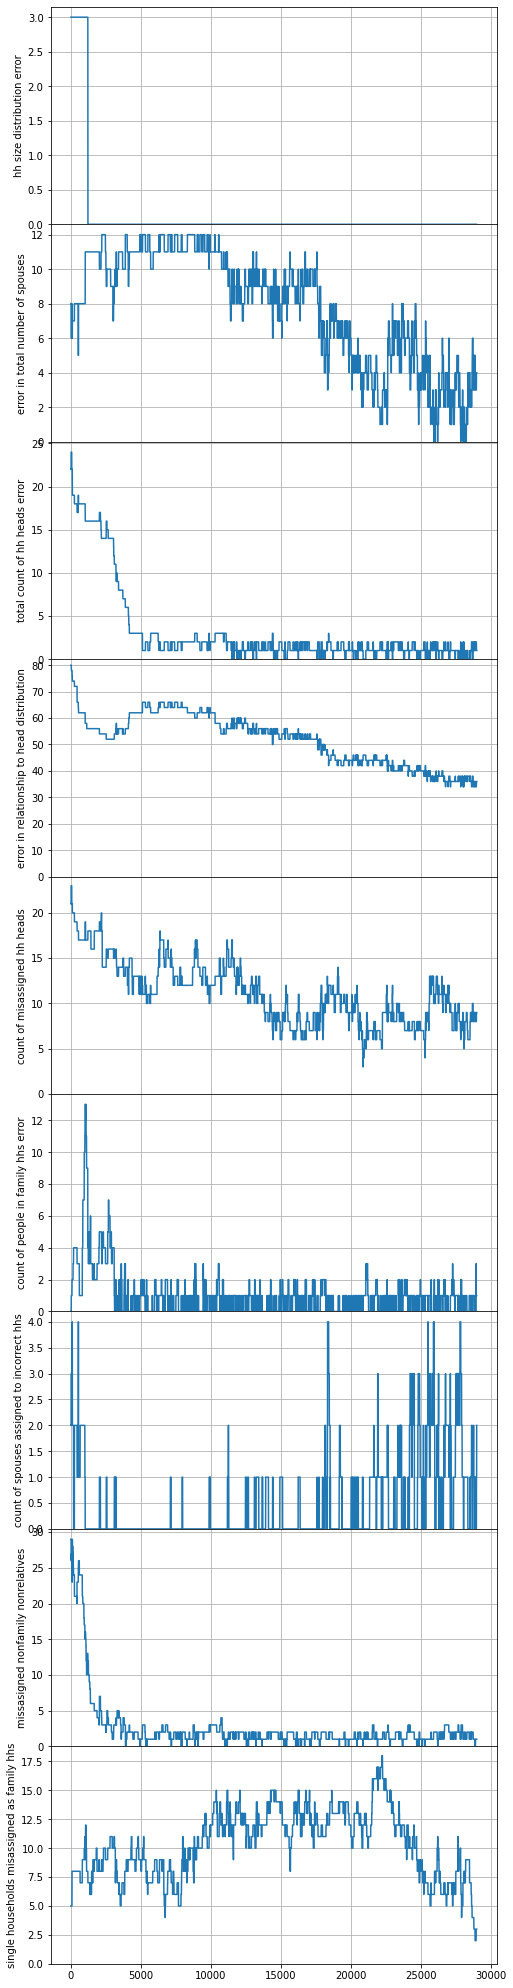

In [82]:
n = 9

fig, axs = plt.subplots(n, sharex=True, gridspec_kw={'hspace': 0}, figsize = (8,4*n))

# fig.suptitle('Trace')

k = 0

y = hh_dist_trace_full
x = np.arange(len(hh_dist_trace_full))

axs[k].plot(x,y)
axs[k].set_ylabel('hh size distribution error')
k += 1

target_spouses = ravenna_relps[ravenna_relps.relp_id==1].counts.values[0]
y = [np.abs(target_spouses - i) for i in spouse_count_trace]
x = np.arange(len(spouse_count_trace))

axs[k].plot(x,y)
axs[k].set_ylabel('error in total number of spouses')
k += 1

target_heads = ravenna_relps[ravenna_relps.relp_id<1].counts.sum()
y = [np.abs(target_heads - i) for i in hh_head_count_trace]
x = np.arange(len(hh_head_count_trace))

axs[k].plot(x,y)
axs[k].set_ylabel('total count of hh heads error')
k += 1

y = np.abs(relp_dist_error_trace)
x = np.arange(len(relp_dist_error_trace))

axs[k].plot(x,y)
axs[k].set_ylabel('error in relationship to head distribution')
k += 1

y = heads_per_hh_error
x = np.arange(len(heads_per_hh_error))

axs[k].plot(x,y)
axs[k].set_ylabel('count of misassigned hh heads')
k += 1

y = np.abs(family_hh_error)
x = np.arange(len(family_hh_error))

axs[k].plot(x,y)
axs[k].set_ylabel('count of people in family hhs error')
k += 1

y = np.abs(spouse_assign_error)
x = np.arange(len(spouse_assign_error))

axs[k].plot(x,y)
axs[k].set_ylabel('count of spouses assigned to incorrect hhs')
k += 1

y = np.abs(nonrel_assign_error)
x = np.arange(len(nonrel_assign_error))

axs[k].plot(x,y)
axs[k].set_ylabel('missasigned nonfamily nonrelatives')
k += 1

y = np.abs(single_hh_assign_error)
x = np.arange(len(single_hh_assign_error))

axs[k].plot(x,y)
axs[k].set_ylabel('single households misassigned as family hhs')
k += 1

for i in range(n):
    axs[i].grid()
    axs[i].set_ylim(ymin=0)

plt.show()

## which draw was best?

In [89]:
error = pd.DataFrame({'hh_distribution':hh_dist_trace_full})

target_spouses = ravenna_relps[ravenna_relps.relp_id==1].counts.values[0]
error['spouses_count'] = [np.abs(target_spouses - i) for i in spouse_count_trace]

target_heads = ravenna_relps[ravenna_relps.relp_id==0].counts.values[0]
error['hh_head_count'] = [np.abs(target_heads - i) for i in hh_head_count_trace]

error['relp_distribution'] = np.abs(relp_dist_error_trace)

error['heads_per_hh'] = heads_per_hh_error

error['family_hh_assign'] = np.abs(family_hh_error)

error['spouse_assign'] = np.abs(spouse_assign_error)

error['nonrel_assign'] = np.abs(nonrel_assign_error)

error['single_hh_assign'] = np.abs(single_hh_assign_error)

In [90]:
error['total'] = error.sum(axis=1)

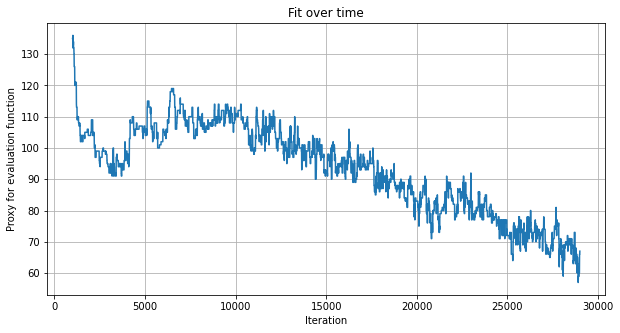

In [91]:
fig = plt.figure(figsize=(10,5))

start = 1000

y = error.total[start:]
x = start + np.arange(error.shape[0]-start)


plt.plot(x,y)
plt.grid()

plt.xlabel('Iteration')
plt.ylabel('Proxy for evaluation function')

plt.title('Fit over time')
plt.show()